This Notebook will produce radial plots that allow the comparison of heterogeneous sets of data from multiple data sources. Specifically, this plots will show the spatial co-localization of different regulatory elements and the local levels of transcription (based on genome-wide ChIP- and RNA-seq data) around a selected locus (central viewpoint)

NOTE: For this notebook you need some additional files inside of "additionalInput" folder:  
-gene_tss.txt contains the genomic locations of the promoters  
-regElem.txt.  contains the genomic locations of the enhancers or other regulatory elements  
-interest_distancePlot.txt contains the genomic locations of the promoters or enhancers of the previous lists for which we want to perform the distance analysis  


-Additionally we will need to have a folder inside additionalInput (in this example "chipExpression_data") with the files containing the signal data we want to include in the plot. The format of the files should be as follows [CellName]\_[feature].txt  
For example: Ery_H3K27ac.txt  
These files must contain at most 3 columns. The first 2 correspond to chromosome and coordinates in which the signal will be assigned. The third column is optional, and can contain a signal value (if absent, all entries will have a value of 1 as default).   
WARNING: The minimum threshold for a signal to be considered to be present is zero. This code wont work with negative threshold values.

# Libraries and functions 

In [1]:
import sys
import cPickle as pickle

## Parameters to modify 

In [2]:
# Maximum number of models to be used. From ~1500 done, we will keep the best 1000
modelsKeep = 1000
# Base path where the folder branch is stored
basePath = '/home/julen/TADdyn/SparseDataModelling/'
# Define the orther of the cells for the ploting
orderCell = ['Ery', 'nCD4', 'Mon']
# Wether to store figures in pdf or not
saveFig = True
# In which of the model clusters we will do the analysis
cluster = 1

## Path to files with coordinates to regulatory elements
# Locations in which we will assign promoters
promFile = basePath + 'additionalInput/gene_tss.txt'
# Locations in which we will assign enhancers or other regulatory elements
enhanFile = basePath + 'additionalInput/regElem.txt'
# Locations of the promoters or enhancers in which we will centre for the radial plot
interestFile = basePath + 'additionalInput/interest_distancePlot.txt'

## Paths to folders with file containing with signal data
# format of the file names must be cell_feature.txt
# I.E.: Ery_H3K27ac.txt
# They should contain at most 3 columns. First two columns correspond to chromosome
# and coordinates in which the signal will be assigned. Third columns can contain
# a signal value. If absent (like in chip peaks data) default value will be 1.
# Signal values bellow 0 are not counted as signal
signalDataFolder = basePath + 'additionalInput/chipExpression_data/'
# The signal threshold associated to this files (if none leave it as None which
# will define 0 by default)
# Allowed lowest value is 0
threshold = 0
# If you want a specific order for this features
markOrder = ['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27ac', 'expression', 
             'H3K27me3', 'H3K9me3']
# otherwise
#markOrder = None
# Size of the first sphere, ideally the contact distance (dcutoff)
firstSphere = 200
# SWe will binarise the inputsignal data and ask for a contingency table
binariseSignal = True
# threshold for significancy
thres = 2  # 2=0.05
# Minimum and maximum odd values to be shown
minMax = [-3, +3]

# Run 

## Import additional libraries 

In [3]:
sys.path.append(basePath + 'code')
import fileHandling
import plotting
import metrics

   ## Define new paths

In [4]:
# Output path for pickles and plots
outdata = basePath + 'outData/modelAnalysis/model_comparisons/radialPlot/'
outplot = basePath + 'outPlot/modelAnalysis/model_comparisons/radialPlot/'

# create folders
! mkdir -p {outdata}
! mkdir -p {outplot}

## Get model files and regions 

In [5]:
## Path were the models are stored
cells, regionsAll, models = fileHandling.getModelsPaths(basePath, ending='models')

## get regions
regiones = {}
# get info of the regions
for cell in cells:
    for regi in regionsAll:
        if not regi in regiones:
            
            regiones[regi] = fileHandling.getREgiInfo(basePath, regi, cell)
        else:
            infot = fileHandling.getREgiInfo(basePath, regi, cell)
            if infot != regiones[regi]:
                print('Region %s, cell %s has different parameters than previous cells')
                print('This code is not prepared to compare models with different length \
                      or resolution')

## Retrieve clustering data 

In [6]:
# If we ran this script with less models, will recover the previous clustering info
clustersPickle= basePath + 'outData/modelAnalysis/clustering/allClusterDict.pickle' 
with open(clustersPickle, "rb") as input_file:
    allClusters = pickle.load(input_file)
print('Recovering previous clustering data from:')
print(clustersPickle)

Recovering previous clustering data from:
/home/julen/TADdyn/SparseDataModelling/outData/modelAnalysis/clustering/allClusterDict.pickle


## Load additional input data 

In [7]:
enhAll, promAll, interAll = fileHandling.getElementCoordinates(regionsAll, regiones, enhanFile,
                          promFile, interestFile)


Enhancer HS-E1 was in same bin as a promoter (HBE1).     Bin position 294
Enhancer enh5 was in same bin as a promoter (STIM1,MIR4687,AC090587.1).     Bin position 12
Enhancer HS5 was in same bin as a promoter (OR51AB1P).     Bin position 299
Enhancer HS7 was in same bin as a promoter (OR51B4).     Bin position 301
Enhancer 3HS1 was in same bin as a promoter (OR51V1).     Bin position 281


Load and binarise ChIP and expression signal data

Just need information indicating if the signal was present in a bin or not.

In [8]:
signalValues = fileHandling.loadSignalFile(signalDataFolder, regiones, orderCell,
                              threshold, binariseSignal=binariseSignal)

## Plot 

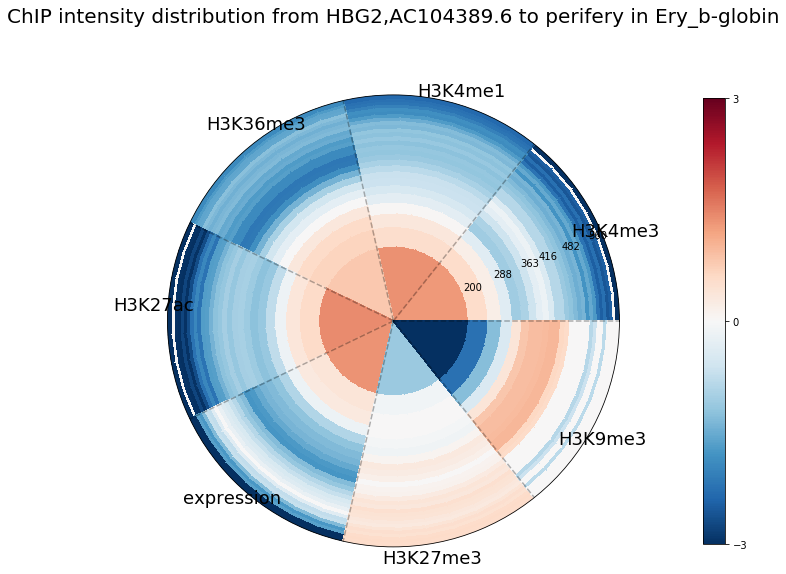

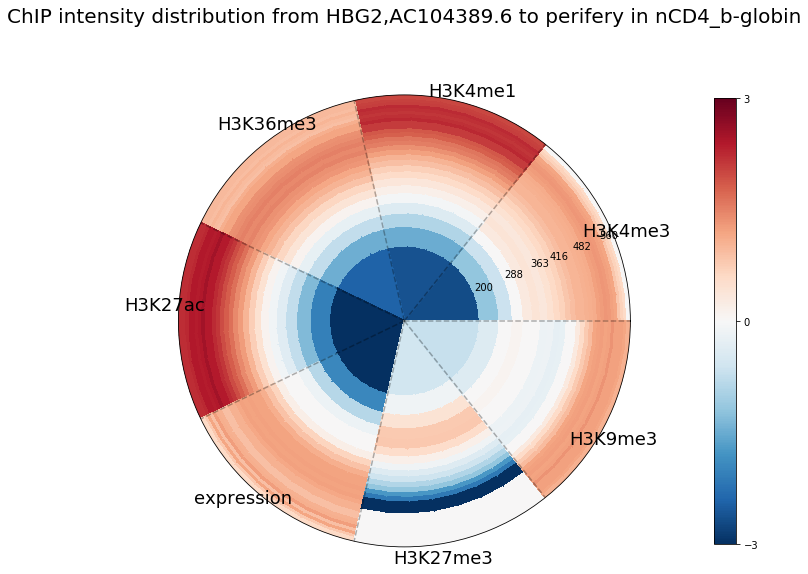

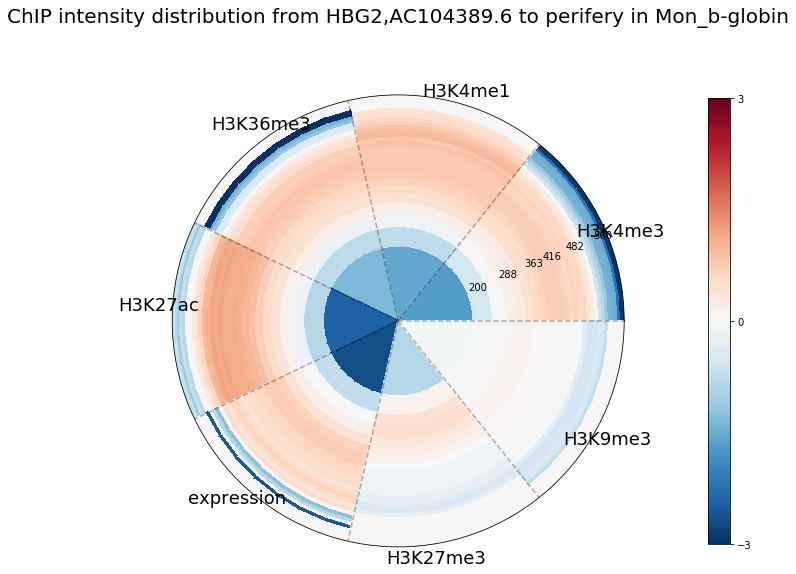

In [9]:
for regi in regionsAll:
    
    # get selection of bins of interest
    selected = []
    selected += [(k, interAll[regi]['promoter'][k]['name']) 
                 for k in interAll[regi]['promoter']]
    selected += [(k, interAll[regi]['enhancer'][k]['name']) 
                 for k in interAll[regi]['enhancer']]
    selected = sorted(list(set(selected)))
    
    plotting.getRadialPlot(selected, signalValues, outplot, regi,  orderCell, 
                           models, modelsKeep, allClusters, firstSphere, 
                           minMax, thres=2, maxRadi=600, 
                          saveFig=saveFig, orderByCluster=False,
                          cluster=cluster, markOrder=markOrder)

